In this set of practice problems, we will replicate the well-documented "reversal effect" in monthly stock returns. This is the finding that, on average, firms with the lowest returns this month, will have the highest returns next month, and firms with the highest returns this month will have the lowest returns next month.

Run the cells below:

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read full crspm file
raw = pd.read_pickle('../data/crspm.zip')

# Calculate market capitalization
raw['mktcap'] = raw['prc'].abs() * raw['shrout']

# Make monthly period date
raw['mdate'] = pd.to_datetime(raw['date']).dt.to_period('M')

# Keep only what we need
crsp = raw[['permno','mdate','ret','mktcap']].copy()
crsp.head()

,permno,mdate,ret,mktcap
0,10000.0,1986-01,NaN,16100.000000
1,10000.0,1986-02,-0.257143,11960.000000
2,10000.0,1986-03,0.365385,16330.000000
3,10000.0,1986-04,-0.098592,15172.000000
4,10000.0,1986-05,-0.222656,11793.859375


Sort ``crsp`` by ``permno`` and ``mdate``. Then use the ``.shift()`` method to create a new variable inside ``crsp`` called ``next_ret`` that gives us next month's return for each firm. Print out the first 4 rows in ``crsp``.

In [3]:
crsp = crsp.sort_values(['permno','mdate'])
crsp['next_ret'] = crsp.groupby('permno')['ret'].shift(-1)
crsp.head(4)

,permno,mdate,ret,mktcap,next_ret
0,10000.0,1986-01,NaN,16100.0,-0.257143
1,10000.0,1986-02,-0.257143,11960.0,0.365385
2,10000.0,1986-03,0.365385,16330.0,-0.098592
3,10000.0,1986-04,-0.098592,15172.0,-0.222656


Drop all the rows in ``crsp`` that have any missing value in any of its columns. Then, each month, split firms into 5 equally-sized bins (quintiles), based on how their current month's return ranked among the rest of the firms this month. Create a new variable inside ``crsp`` called ``ret_quint`` which tells us which firm is in which quintile at each point in time. We'll refer to each quintile as a "portfolio" going forward.

In [4]:
crsp = crsp.dropna()
crsp['ret_quint'] = crsp.groupby('mdate')['ret'].transform(lambda x:
                                                               pd.qcut(x, q=5, labels=range(1,6)))
crsp.head()

,permno,mdate,ret,mktcap,next_ret,ret_quint
1,10000.0,1986-02,-0.257143,11960.000000,0.365385,1
2,10000.0,1986-03,0.365385,16330.000000,-0.098592,5
3,10000.0,1986-04,-0.098592,15172.000000,-0.222656,1
4,10000.0,1986-05,-0.222656,11793.859375,-0.005025,1
5,10000.0,1986-06,-0.005025,11734.593750,-0.080808,3


Calculate average "next-month" returns (``next_ret``) every month for every quintile portfolio. Store these "equal-weighted" portfolio returns in a separate dataframe called ``ewret``. Display the first 10 rows of ``ewret``.

In [5]:
ewret = crsp.groupby(['mdate','ret_quint'])['next_ret'].mean().to_frame()
ewret.head(10)

next_ret
mdate   ret_quint          
1980-01 1         -0.006561
        2          0.004894
        3         -0.019758
        4         -0.005123
        5         -0.011344
1980-02 1         -0.156343
        2         -0.140676
        3         -0.151162
        4         -0.168752
        5         -0.216101

Print the time-series of monthly equal-weighted "next-month" returns for each of the five quintile portfolios (i.e. one subplot for each portfolio, figure size 10 by 10).

In [6]:
#Reshape ``ewret`` to wide
ewret_long = ewret.reset_index().pivot(index='mdate', columns='ret_quint')
ewret_long.head()

next_ret                                        
ret_quint         1         2         3         4         5
mdate                                                      
1980-01   -0.006561  0.004894 -0.019758 -0.005123 -0.011344
1980-02   -0.156343 -0.140676 -0.151162 -0.168752 -0.216101
1980-03    0.079345  0.070277  0.041728  0.029025  0.040854
1980-04    0.088379  0.069048  0.079175  0.067341  0.048562
1980-05    0.058590  0.050547  0.041370  0.044864  0.023512

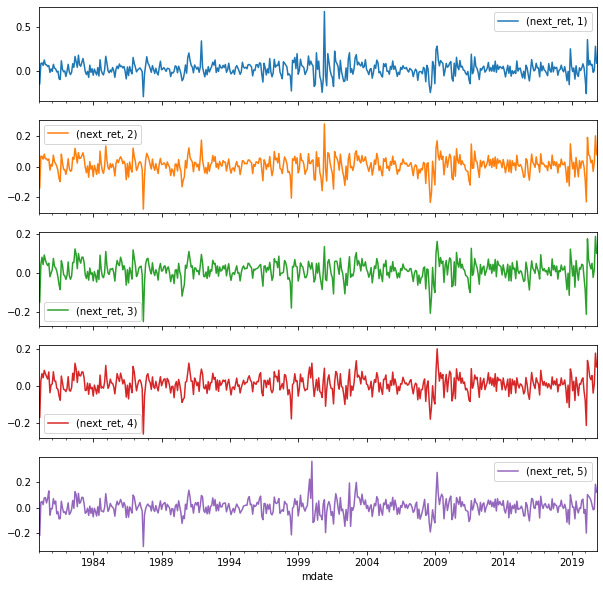

In [7]:
ewret_long.plot(subplots = True, figsize=(10,10));

Compound the equal-weighted "next-month" returns for each of the five portfolios, at each point in time, and plot these five compounded-return time-series in the same graph.

In [8]:
ewret_compound = (1 + ewret_long).cumprod()
ewret_compound

next_ret                                              
ret_quint            1           2           3           4         5
mdate                                                               
1980-01       0.993439    1.004894    0.980242    0.994877  0.988656
1980-02       0.838122    0.863530    0.832067    0.826990  0.775007
1980-03       0.904623    0.924216    0.866787    0.850994  0.806669
1980-04       0.984572    0.988032    0.935415    0.908300  0.845843
1980-05       1.042258    1.037974    0.974113    0.949050  0.865730
...                ...         ...         ...         ...       ...
2020-07    1270.544145   99.540440  122.143416   94.347606  6.562670
2020-08    1243.956794   96.573547  119.182647   90.820335  6.455118
2020-09    1244.609830   99.397452  121.094149   91.873701  6.386850
2020-10    1592.909640  119.661131  143.540026  108.203580  7.543839
2020-11    1728.116680  129.256320  157.739180  119.410003  8.449145

[491 rows x 5 columns]

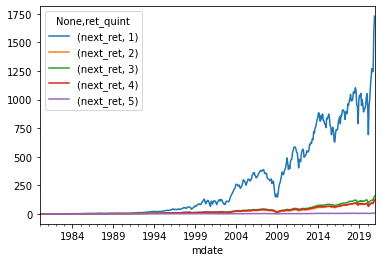

In [9]:
ewret_compound.plot();

Which portfolio has the highest compounded equal-weighted return over the entire sample?

In [10]:
ewret_compound.iloc[-1] 

          ret_quint
next_ret  1            1728.116680
          2             129.256320
          3             157.739180
          4             119.410003
          5               8.449145
Name: 2020-11, dtype: float64

Print a 5 x 2 table, where the two columns give us the full-sample mean and standard deviation of equal-weighted "next-month" returns for each of the five portfolios. Does the risk-return trade-off seem to apply to these five portfolios?

In [11]:
ewret.groupby('ret_quint')['next_ret'].agg(['mean','std'])

,mean,std
ret_quint,,
1,0.018808,0.085570
2,0.011656,0.057899
3,0.011593,0.049161
4,0.011022,0.049268
5,0.006283,0.061956
